Welcome to part 2 of this tutorial! Now we're switching gears to Python. In this tutorial, we're going to use the rasters we created from our point cloud using the `lidR` and `terra` packages in **R**. You should have two rasters saved to your working directory. For this notebook to work without requiring you to change file names in the code, the file paths are `Data/example_raster_hmax.tif` and `Data/example_raster_hmean.tif`. With these rasters, we can retrieve information about the vegetation surrounding a home for the purpose of assessing wildfire risk. 

Predicting wildfire risk to a home is a complicated endeavor, but we're going to make it simple since this tutorial does not require expertise in the matter. I'll just point to two of the best and most popular home hazard mitigation frameworks available in the US: one is an approachable homeowner checklist from the National Fire Protection Association (NFPA)[https://www.nfpa.org/en/downloadable-resources/safety-tip-sheets/how-to-prepare-your-home-for-wildfires] and the other is a more rigorous series of linked assessment forms from the National Institute for Science and Technology (NIST) - Technical Note 2205[https://www.nist.gov/el/fire-research-division-73300/wildland-urban-interface-fire-73305/hazard-mitigation-methodology-2]. The former is written for homeowners and the latter is written for assessors.

It's recommended to read the NFPA one-pager if you're not familiar with concepts like the home ignition zone (HIZ) and defensible space, as I will be referencing these throughout the document.

Okay, let's kick it off by loading in the required packages and then the rasters!

In [25]:
import rasterio as rio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

hmax = rio.open('Data/example_raster_hmax.tif')
hmean = rio.open('Data/example_raster_hmean.tif')

It's important to know that `rio` opens files in read mode, and that mode must be changed to manipulate the raster.

In [12]:
hmax.mode

'r'

We can look at some of the features of these rasters.

In [9]:
print(hmean.shape)
print(hmean.indexes)
print(hmean.dtypes)
hmean.transform

(1000, 1001)
(1,)
('float32',)


Affine(1.0, 0.0, -951001.0,
       0.0, -1.0, 1797000.0)

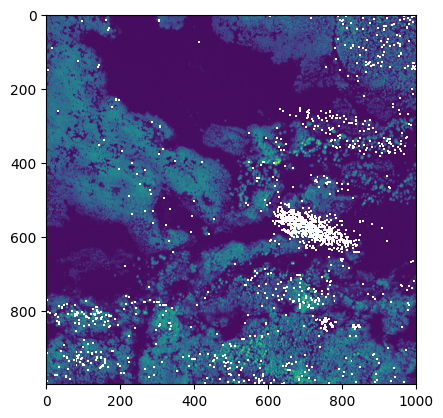

In [10]:
plt.imshow(hmean.read(1))

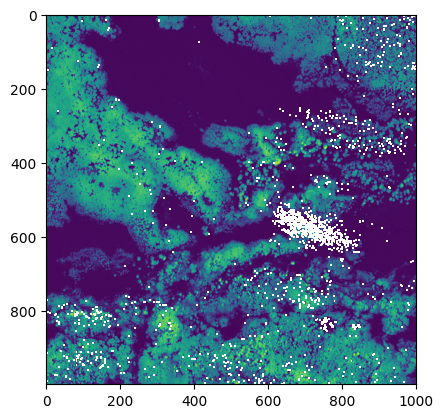

In [11]:
plt.imshow(hmax.read(1))

These rasters are simply 2D grids where each cell represents a 3D value: height. 

You can see that we have some missing values for pixels in our rasters. We can fill these in with a 3x3 moving window that 'scans' the image pixel by pixel and fills in missing values with the average value of the 8 surrounding pixels.

Since this works best on arrays, let's save each raster as a numpy array.

In [15]:
# Saving as arrays is easy
arr_hmax = hmax.read(1)
arr_hmean = hmean.read(1)

# Let's make sure they are arrays
arr_hmax

array([[  nan, 19.17, 18.89, ...,  9.99, 12.2 , 13.94],
       [  nan, 19.  , 19.09, ..., 13.78, 12.94, 16.83],
       [  nan, 19.98, 18.88, ..., 14.09, 14.42, 17.32],
       ...,
       [  nan, 22.18, 19.7 , ...,  3.03,  3.08,  2.66],
       [  nan, 22.54, 21.71, ...,  3.36,  3.54,  3.49],
       [  nan, 23.03, 22.56, ...,  4.07,  3.36,  3.22]], dtype=float32)

Excellent! Now let's create a 3x3 moving window to target and fill in NaN values.

First, we define what the window does. We'll call this function `fill_nan`. Fortunately, we do not have to manually program it to scan the image. We use `generic_filter` from the `scipy` library, which does this automatically. We just have to give it three arguments: the **array** to filter, the **function** of the window, and the **size** of the window. Optionally, we can set **mode** based on how we want to treat pixels outside of the array. Let's stick with the default *reflect*. You can read more about options here: [https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.generic_filter.html]

In [ ]:
from scipy.ndimage import generic_filter

# Define a function to compute the mean within a window
def fill_nan(window):
    valid_values = window[~np.isnan(window)]  # Exclude NaN values from calculation of mean
    if len(valid_values) > 0:
        return np.mean(valid_values)
    else:
        return 0  # If all values in the window are NaN, return 0

# Apply the moving window function to fill missing values
window_size = (3, 3)
arr_max = generic_filter(arr_hmax, fill_nan, size=window_size, mode='reflect')
arr_mean = generic_filter(arr_hmean, fill_nan, size=window_size, mode='reflect')

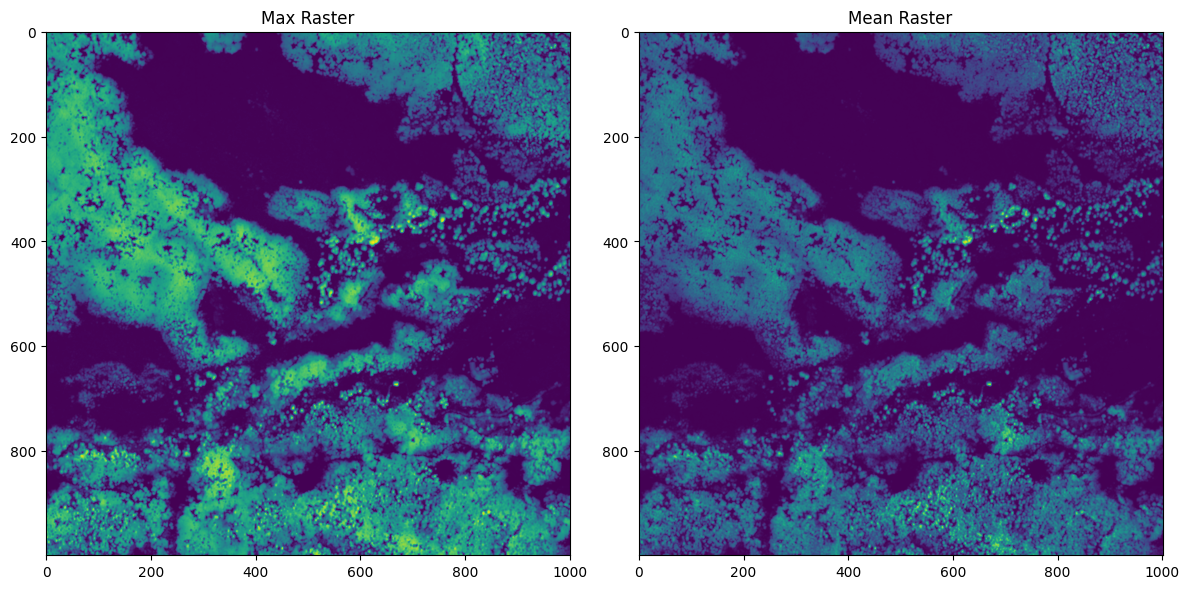

In [48]:
# Let's plot the new outputs to see the fruits of our toils
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(arr_max, cmap='viridis') 
ax1.set_title('Max Raster') 

ax2.imshow(arr_mean, cmap='viridis')
ax2.set_title('Mean Raster') 

plt.tight_layout()

plt.show()

Simply beautiful.

Now let's do something interesting with these rasters. We're going to load in the same shapefile `example_footprint.shp` that we used in the first part of this tutorial and make sure the CRS aligns with the rasters. Then, we're going to create 3 home ignition zones around the building footprint according to NFPA standards, and look at the vegetation within it to get an idea of how much the vegetation around this home is contributing to its wildfire risk.

In [31]:
hmax.crs

CRS.from_wkt('LOCAL_CS["NAD83(2011) / Conus Albers + NAVD88 height - Geoid12B (m)",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [41]:
# Read in the shapefile
gdf = gpd.read_file("Data/Gunnison_County_Buildings/example_footprint.shp") # gdf stands for GeoDataFrame
gdf

,FID,County,geometry
0,1439807,Gunnison County,"POLYGON ((-950222.010 1796808.097, -950219.690..."


We can see that there is only one object in this GeoDataFrame. It is a building footprint. Let's make a function that creates home ignition zones around the building footprint. Importantly, these zones should not overlap, since we want to perform analysis on the raster within each zone.

In [42]:
# Define a function `hiz` to create home ignition zone geometries from building footprints and specified distances
def get_hiz(footprints, z1 = 2, z2 = 10, z3 = 30):
   
    '''
    Enhances a GeoDataFrame of building footprints with additional columns for home ignition zones.
    
    NOTES: 
        - The unit of measurement will depend on your CRS (assumes CRS units in meters)
        - The zones do not overlap
    
    Parameters
    ------------------
    - footprints: GeoDataFrame with building footprints.
    - z1, z2, z3: Distances (m) for the respective zones around each footprint.
    
    Returns:
    ------------------
    - GeoDataFrame with original footprints and additional columns for each zone's buffer.
    
    '''

    # Define distances
    # Subtracts the previous zones so that total distance from home is the distance specified, but zones do not overlap
    dist_z1 = z1
    dist_z2 = z2 - z1
    dist_z3 = z3 - (z1 + z2)

    # Start with 'footprints' and buffer with '(distance = z1)'
    footprints['buffer_z1'] = footprints.buffer(distance = dist_z1).difference(footprints['geometry'])
    footprints['buffer_z2'] = footprints['geometry'].buffer(distance = dist_z2).difference(footprints['geometry'].buffer(dist_z1))
    footprints['buffer_z3'] = footprints['geometry'].buffer(distance = dist_z3).difference(footprints['geometry'].buffer(dist_z2))
    
    # Return enhanced GeoDataFrame
    return footprints

This function will work on a shapefile containing multiple footprints, but to keep things simple, we're just going to do it for this single footprint. 
Now let's put this function to use!

In [43]:
# Create a new geodataframe
hiz = get_hiz(gdf)
hiz

,FID,County,geometry,buffer_z1,buffer_z2,buffer_z3
0,1439807,Gunnison County,"POLYGON ((-950222.010 1796808.097, -950219.690...","POLYGON ((-950222.604 1796806.187, -950222.788...","POLYGON ((-950224.387 1796800.458, -950225.121...","POLYGON ((-950232.805 1796832.461, -950231.537..."


In [45]:
# In order to save a shapefile of HIZs, each geometry column needs to be saved as a separate shapefile
# Make sure each file contains one geometry column, and also 'FID' and "County'.
geom_cols = ['geometry', 'buffer_z1', 'buffer_z2', 'buffer_z3']
non_geom_cols = ['FID', 'County']

# Iterate and save each as a separate Shapefile
for geom_col in geom_cols:
    # Create a temporary GeoDataFrame with only the current geometry column and non-geometry columns
    temp_gdf = hiz[non_geom_cols + [geom_col]].copy()
    temp_gdf.set_geometry(geom_col, inplace=True)  # Loop through columns, setting each as the geometry column
    
    # Save to Shapefile
    temp_gdf.to_file(f'Data/hiz_{geom_col}.shp') # Edit filepath as needed to save to your working directory

Now we're going to define each shapefile as its own object and load all of them into our environment as GeoDataFrames.

In [49]:
footprint = gpd.read_file("Data/hiz_geometry.shp")
z1 = gpd.read_file("Data/hiz_buffer_z1.shp")
z2 = gpd.read_file("Data/hiz_buffer_z2.shp")
z3 = gpd.read_file("Data/hiz_buffer_z3.shp")

We're going to clip our rasters to the extent of the given geometry for each of these. But first, some housekeeping and preparation. Let's first close our open datasets for cleanliness.

In [51]:
hmax.close()
hmean.close()

print(hmax.closed)
print(hmean.closed)

True
True


In [66]:
hmax = rio.open('Data/example_raster_hmax.tif')

Now, referring back to what you learned from the NFPA one-pager (or to what you know about wildfire risk to homes in general), how can we use max height values on a 1m x 1m grid to derive a metric that can be linked to wildfire risk?

Hint: We created a geometry for each zone because fire risk is influenced by the height and density of vegetation, and the NFPA requirements for height and density of vegetation is different with increasing distance from the home. So what can we do with max height values to audit NFPA vegetation compliance?

Answer: Our simplified proxy for NFPA compliance is going to be the **average max height** of vegetation pixels within each zone.

We'll tackle this one step at a time. First, we're going to mask the max height raster with each HIZ geometry - `z1`, `z2`, and `z3`. To do this, we have to rasterize each geometry. The following 3 code blocks accomplish that, and save the masked raster outputs to files.

In [67]:
from rasterio.mask import mask
from rasterio.io import MemoryFile

# Prepare geometries from GeoDataFrame for masking
geoms = z1['geometry'].values # Zone 1

# Create a new in-memory dataset
with MemoryFile() as memfile:
    # Define metadata based on the properties of arr_max
    meta = {
        'driver': 'GTiff',
        'dtype': 'float32',
        'count': 1,
        'width': arr_max.shape[1],
        'height': arr_max.shape[0],
        'crs': hmax.crs,  # Update with the correct CRS as necessary
        'transform': hmax.transform,  # Update with the correct transform if available
        'nodata': np.nan
    }

    with memfile.open(**meta) as hmax_dataset:
        # Write arr_max to the in-memory dataset
        hmax_dataset.write(arr_max, 1)

        # Apply the mask using the geometries
        z1_out_values, z1_out_transform = mask(hmax_dataset, geoms, crop=True, nodata=np.nan)


In [68]:
geoms = z2['geometry'].values # Zone 2

# Create a new in-memory dataset
with MemoryFile() as memfile:
    # Define metadata based on the properties of arr_max
    meta = {
        'driver': 'GTiff',
        'dtype': 'float32',
        'count': 1,
        'width': arr_max.shape[1],
        'height': arr_max.shape[0],
        'crs': hmax.crs,  # Update with the correct CRS as necessary
        'transform': hmax.transform,  # Update with the correct transform if available
        'nodata': np.nan
    }

    with memfile.open(**meta) as hmax_dataset:
        # Write arr_max to the in-memory dataset
        hmax_dataset.write(arr_max, 1)

        # Apply the mask using the geometries
        z2_out_values, z2_out_transform = mask(hmax_dataset, geoms, crop=True, nodata=np.nan)


In [69]:
geoms = z3['geometry'].values # Zone 3

# Create a new in-memory dataset
with MemoryFile() as memfile:
    # Define metadata based on the properties of arr_max
    meta = {
        'driver': 'GTiff',
        'dtype': 'float32',
        'count': 1,
        'width': arr_max.shape[1],
        'height': arr_max.shape[0],
        'crs': hmax.crs,  # Update with the correct CRS as necessary
        'transform': hmax.transform,  # Update with the correct transform if available
        'nodata': np.nan
    }

    with memfile.open(**meta) as hmax_dataset:
        # Write arr_max to the in-memory dataset
        hmax_dataset.write(arr_max, 1)

        # Apply the mask using the geometries
        z3_out_values, z3_out_transform = mask(hmax_dataset, geoms, crop=True, nodata=np.nan)


Next, let's define a function for computing the average value of all the pixels.

We're going to reverse-engineer this function a little. We know that our zones are all donut-shaped. If we divide the sum of the pixels by the size of the array, then pixels both inside and outside the donut will be included in the size, and that will throw off our calculation. The above 3 code blocks have set all the values outside and inside of the donuts to `NaN`, so now we make sure our `calculate_avg` function divided by the number of *non-NaN* pixels in the array.

In [70]:
def calculate_avg(arr):
    
    # Count non-NaN values in the array
    non_nan_count = np.sum(~np.isnan(arr))
    # Compute the sum of non-NaN values
    non_nan_sum = np.sum(arr[~np.isnan(arr)])
    # Calculate the average (handle case when non_nan_count is 0 to avoid division by zero)
    avg = non_nan_sum / non_nan_count if non_nan_count > 0 else np.nan

    return avg

All that's left to do is calculate the average max height per zone. Here are the results:

In [71]:
calculate_avg(z3_out_values)

2.3484971919686135

In [72]:
calculate_avg(z2_out_values)

3.054104777520576

In [73]:
calculate_avg(z1_out_values)

3.9157764165088382

There are some insights and some caveats to draw from this from a fire mitigation perspective.

For a NFPA-compliant home ignition zone, we would expect to see taller average height values further away from the home. Instead, we are seeing the reverse.

The Z1 values have possibly been skewed by the home itself. Since the Microsoft building footprint does not perfectly align with the location of the building in the point cloud, it is likely that the building itself has been included in the max height calculation. A way to handle this would be to classify the point cloud to include buildings, and derive the building footprint directly from the LiDAR data.

The Z2 and Z3 values are probably more reliable. It tells us that there is tall vegetation surrounding the home. If the average height exceeds 3m in Z2, it is likely that this property could benefit from removing some trees and ensuring that the ground is clear of continuous flammable fuels. Since Z3 average max height is lower, it's likely that Z3 will not carry fire, although the average max height could be skewed by clumps of tall, continuous forest fuels interspersed with grassland, which is typical of this environment.

My conclusion is that average max height does not produce an actionable insight for home risk reduction. There is potential to develop better ways of producing actionable insights for home wildfire risk mitigation, but none have been developed (based on a meticulous review of over 150 papers and models). While the results presented here may prove to be a useful predictor in a random forest or multi-layer perceptron model, I will continue to test the value of different LiDAR metrics using the framework developed through this project.